In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

In [2]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_palette('Set2')
plt.style.use('ggplot')

In [3]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 12
fig_size[1] = 8

In [4]:
df = pd.read_excel('資產配置.xlsx', sheetname='月報酬', index_col='date')

In [5]:
eng_columns = ['SP500', 'Russel2000', 'DM Stocks ex US', 'EM Stocks', 'US Bonds', 'Gold', 'Commodities', 'Reits']

In [8]:
nav = np.cumprod(1+df.pct_change().fillna(0))

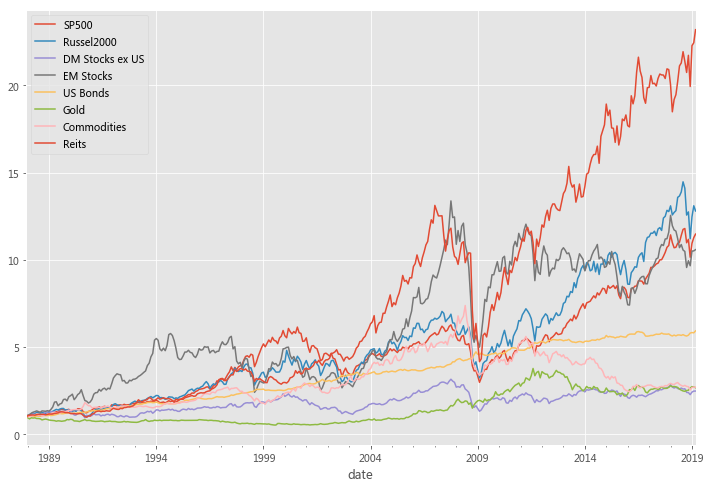

In [9]:
nav.plot()

In [10]:
monthly_returns = nav.pct_change().fillna(0)

In [11]:
#计算组合收益率分析:年化收益率、收益波动率、夏普比率、最大回撤
def strategy_performance (nav_df):
    
    ##part1:根据回测净值计算相关指标的数据准备（日度数据）
    #nav_next=nav_df.shift(1)
    return_df=nav_df.pct_change().dropna() #计算净值变化率，即为日收益率,包含组合与基准
   
    analyze=pd.DataFrame()  #用于存储计算的指标
    
    ##part2:计算年化收益率
    #cum_return=np.exp(np.log1p(return_df).cumsum())-1   #计算整个回测期内的复利收益率
    #annual_return_df=(1+cum_return)**(252/len(return_df))-1  #计算年化收益率
    #analyze['annual_return']=annual_return_df.iloc[-1]  #将年化收益率的Series赋值给数据框
    years = len(nav_df)/12
    analyze['annual_return']=nav_df.iloc[-1]**(1/years)-1  #将年化收益率的Series赋值给数据框
    
    #part3:计算收益波动率（以年为基准）
    analyze['return_volatility']=return_df.std()*np.sqrt(12) #return中的收益率为日收益率，所以计算波动率转化为年时，需要乘上np.sqrt(252)
    
    #part4:计算夏普比率
    risk_free=0.02
    return_risk_adj=return_df-risk_free
    #analyze['sharpe_ratio']= return_risk_adj.mean()/np.std(return_risk_adj, ddof=1)
    analyze['sharpe_ratio']= (analyze['annual_return']-risk_free)/analyze['return_volatility']
    
    #prat5:计算最大回撤
    cumulative=np.exp(np.log1p(return_df).cumsum())*100  #计算累计收益率
    max_return=cumulative.cummax()  #计算累计收益率的在各个时间段的最大值
    analyze['max_drawdown']=cumulative.sub(max_return).div(max_return).min()  #最大回撤一般小于0，越小，说明离1越远，各时间点与最大收益的差距越大
    
    return analyze 

In [12]:
nav.tail()

,SP500,Russel2000,DM Stocks ex US,EM Stocks,US Bonds,Gold,Commodities,Reits
date,,,,,,,,
2018-11-30,11.171159,12.744718,2.389016,9.9472,5.679354,2.521215,2.725688,21.720315
2018-12-31,10.145904,11.209408,2.270619,9.6578,5.801549,2.649225,2.537952,19.933708
2019-01-31,10.944229,12.463377,2.417440,10.4993,5.828860,2.729291,2.676181,22.275473
2019-02-28,11.269589,13.096180,2.473721,10.5095,5.813059,2.712911,2.703275,22.437739
2019-03-29,11.471588,12.798522,2.475979,10.5813,5.924031,2.669655,2.698449,23.189381


In [13]:
strategy_performance(nav)

,annual_return,return_volatility,sharpe_ratio,max_drawdown
SP500,0.080980,0.140666,0.433511,-0.525559
Russel2000,0.084763,0.184024,0.351927,-0.540802
DM Stocks ex US,0.029358,0.166409,0.056234,-0.582353
EM Stocks,0.078197,0.224583,0.259133,-0.626678
US Bonds,0.058420,0.044043,0.872318,-0.054186
Gold,0.031835,0.151732,0.077999,-0.441747
Commodities,0.032188,0.143962,0.084664,-0.670252
Reits,0.105536,0.178950,0.477992,-0.682965


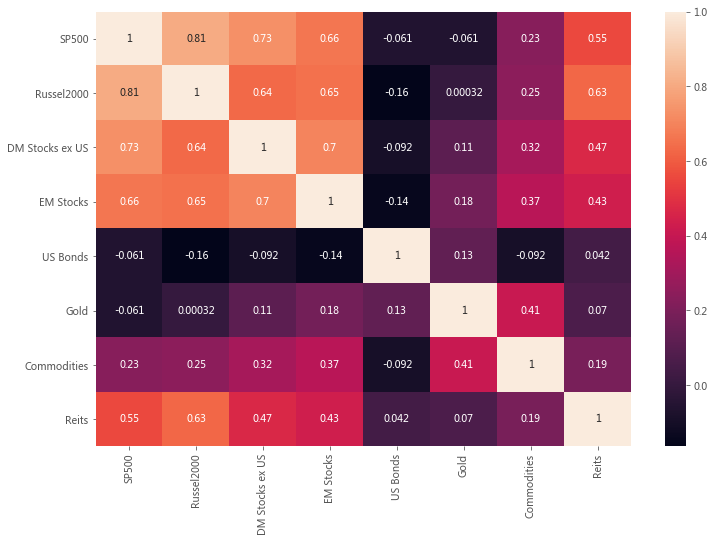

In [14]:
sns.heatmap(monthly_returns.corr(),annot=True)

In [15]:
corr_df = pd.DataFrame()

In [16]:
for i in range(len(monthly_returns)-120):
    temp = pd.DataFrame(monthly_returns[i:120+i].corr().iloc[0]).T
    corr_df = pd.concat([corr_df,temp])

In [17]:
corr_df.index = monthly_returns[120:].index

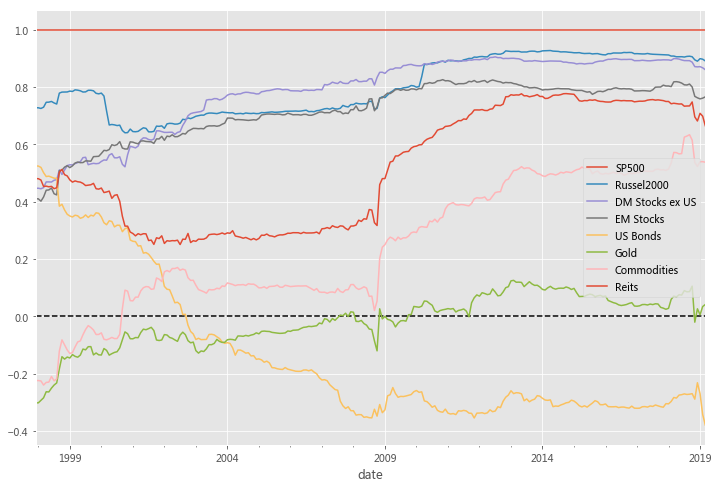

In [18]:
corr_df.plot()
plt.hlines(0,corr_df.index[0], corr_df.index[-1], color='k', linestyles='dashed')

In [19]:
class Backtest():
    def __init__(self, price):
        self.price = price
        self.nav = np.cumprod(1+price.pct_change().fillna(0))
    
    def DD_plot(self, nav):
        #max_return = nav.cummax()
        #plt.plot(nav.index, nav.sub(max_return).div(max_return))
        #plt.fill_between(nav.index, 0, nav.sub(max_return).div(max_return), alpha=0.4)
        #plt.legend(fontsize=15)
        fig_size[0] = 12
        fig_size[1] = 12
        plt.figure()

        rect1 = [0.14, 0.35, 0.9, 0.3] # [左, 下, 宽, 高] 规定的矩形区域 （全部是0~1之间的数，表示比例）
        rect2 = [0.14, 0.15, 0.9, 0.15]
        ax1 = plt.axes(rect1)
        ax2 = plt.axes(rect2)
        ax1.plot(nav)
        ax1.legend(nav.columns, fontsize=15)
        plt.title('Drawdowns')
        ax2.plot(nav.sub(nav.cummax()).div(nav.cummax()))
        ax2.legend(nav.columns)
        
    def No_rebalance(self, initial_weight, name=False):
        port_nav = 0
        for asset in initial_weight:
            port_nav += self.nav[asset]*initial_weight[asset]
        if name:
            port_nav.name = name
        return port_nav
    
    def Rebalance(self, initial_weight, freq='1yr',name=False):
        port_nav_list = []
        assets_weight = initial_weight.copy()
        returns = self.nav.pct_change().fillna(0)+1
        for date in self.nav.index:
            for asset in assets_weight.keys():
                assets_weight[asset] = assets_weight[asset]*returns[asset][date]
            port_nav_list.append(sum([assets_weight[asset] for asset in assets_weight.keys()]))
            if freq == '1yr':
                if date.month == 12:
                    for asset in assets_weight.keys():
                        assets_weight[asset] = port_nav_list[-1]*initial_weight[asset] 
            elif freq == '6m':
                if date.month == 6 or date.month == 12:
                    for asset in assets_weight.keys():
                        assets_weight[asset] = port_nav_list[-1]*initial_weight[asset] 
                
        return pd.Series(port_nav_list,index=self.nav.index)
    
    def risk_con_meanXm(self, window_months=12, if_ewm=False):
        mean = self.price.rolling(window=window_months).mean().fillna(0)
        if if_ewm:
            mean = self.price.ewm(span=window_months,adjust= True).mean().fillna(0)
        returns = self.nav.pct_change().fillna(0)+1
        logic = (df > mean).shift(1).fillna(True)
        returns_mean = returns[logic].fillna(1)
        return np.cumprod(returns_mean)
    

In [20]:
nav.tail()

,SP500,Russel2000,DM Stocks ex US,EM Stocks,US Bonds,Gold,Commodities,Reits
date,,,,,,,,
2018-11-30,11.171159,12.744718,2.389016,9.9472,5.679354,2.521215,2.725688,21.720315
2018-12-31,10.145904,11.209408,2.270619,9.6578,5.801549,2.649225,2.537952,19.933708
2019-01-31,10.944229,12.463377,2.417440,10.4993,5.828860,2.729291,2.676181,22.275473
2019-02-28,11.269589,13.096180,2.473721,10.5095,5.813059,2.712911,2.703275,22.437739
2019-03-29,11.471588,12.798522,2.475979,10.5813,5.924031,2.669655,2.698449,23.189381


In [33]:
df.head()

,SP500,Russel2000,DM Stocks ex US,EM Stocks,US Bonds,Gold,Commodities,Reits
date,,,,,,,,
1987-12-31,247.08,120.306,757.45,100.00,382.26,484.10,62.9327,802.51
1988-01-29,257.07,125.323,770.13,109.42,395.04,458.00,63.6762,846.49
1988-02-29,267.82,136.332,820.63,109.68,399.16,426.15,62.6957,878.86
1988-03-31,258.89,142.497,870.17,120.64,394.70,456.95,65.2636,883.23
1988-04-29,261.33,145.599,881.86,126.27,392.48,449.00,67.0210,889.37


In [34]:
backtest = Backtest(df)

# 無再平衡 

In [23]:
weight_60_40 = {'SP500':0.6,
               'Russel2000':0,
               'DM Stocks ex US':0,
               'EM Stocks':0,
               'US Bonds':0.4,
               'Gold':0,
               'Commodities':0,
               'Reits':0,}
weight_tobias = {'SP500':1/3,
               'Russel2000':0,
               'DM Stocks ex US':1/3,
               'EM Stocks':0,
               'US Bonds':1/3,
               'Gold':0,
               'Commodities':0,
               'Reits':0,}
weight_bernstein = {'SP500':0.25,
               'Russel2000':0.25,
               'DM Stocks ex US':0.25,
               'EM Stocks':0,
               'US Bonds':0.25,
               'Gold':0,
               'Commodities':0,
               'Reits':0,}
weight_ivy = {'SP500':0.2,
               'Russel2000':0,
               'DM Stocks ex US':0.2,
               'EM Stocks':0,
               'US Bonds':0.2,
               'Gold':0,
               'Commodities':0.2,
               'Reits':0.2,}
weight_swensen = {'SP500':0.3,
               'Russel2000':0,
               'DM Stocks ex US':0.15,
               'EM Stocks':0.05,
               'US Bonds':0.3,
               'Gold':0,
               'Commodities':0,
               'Reits':0.2,}


In [24]:
portfolios = pd.DataFrame()

In [28]:
portfolios['SP500'] = nav['SP500']
portfolios['60-40(no rebalanced)']  = backtest.No_rebalance(weight_60_40)
portfolios['tobias(no rebalanced)']  = backtest.No_rebalance(weight_tobias)
portfolios['bernstein(no rebalanced)']  = backtest.No_rebalance(weight_bernstein)
portfolios['ivy(no rebalanced)']  = backtest.No_rebalance(weight_ivy)
portfolios['swensen(no rebalanced)']  = backtest.No_rebalance(weight_swensen)

In [29]:
strategy_performance(portfolios)

,annual_return,return_volatility,sharpe_ratio,max_drawdown
SP500,0.080980,0.140666,0.433511,-0.525559
60-40(no rebalanced),0.073589,0.092894,0.576889,-0.328168
tobias(no rebalanced),0.062199,0.090963,0.463911,-0.341753
bernstein(no rebalanced),0.069324,0.112194,0.439632,-0.405536
ivy(no rebalanced),0.073214,0.102587,0.518726,-0.471107
swensen(no rebalanced),0.078764,0.107518,0.546550,-0.463085


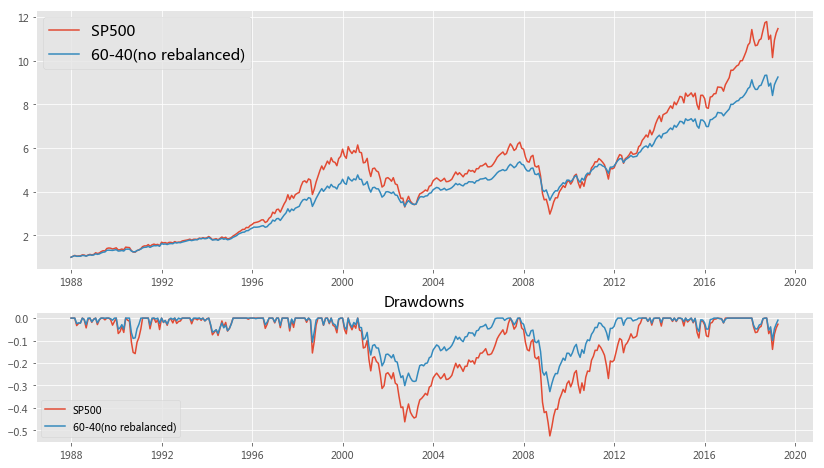

In [30]:
backtest.DD_plot(portfolios[['SP500', '60-40(no rebalanced)']])

# 再平衡(年底)

In [27]:
portfolios_re1yr = pd.DataFrame()

In [28]:
portfolios_re1yr['60-40(no rebalanced)'] = backtest.No_rebalance(weight_60_40)
portfolios_re1yr['60-40(rebalanced yearly)']  = backtest.Rebalance(weight_60_40, freq='1yr')
portfolios_re1yr['tobias(no rebalanced)'] = backtest.No_rebalance(weight_tobias)
portfolios_re1yr['tobias(rebalanced yearly)']  = backtest.Rebalance(weight_tobias, freq='1yr')
portfolios_re1yr['bernstein(no rebalanced)'] = backtest.No_rebalance(weight_bernstein)
portfolios_re1yr['bernstein(rebalanced yearly)']  = backtest.Rebalance(weight_bernstein, freq='1yr')
portfolios_re1yr['ivy(no rebalanced)'] = backtest.No_rebalance(weight_ivy)
portfolios_re1yr['ivy(rebalanced yearly)']  = backtest.Rebalance(weight_ivy, freq='1yr')
portfolios_re1yr['swensen(no rebalanced)'] = backtest.No_rebalance(weight_swensen)
portfolios_re1yr['swensen(rebalanced yearly)']  = backtest.Rebalance(weight_swensen, freq='1yr')

In [29]:
strategy_performance(portfolios_re1yr)

,annual_return,return_volatility,sharpe_ratio,max_drawdown
60-40(no rebalanced),0.073589,0.092894,0.576889,-0.328168
60-40(rebalanced yearly),0.076354,0.083814,0.672365,-0.293314
tobias(no rebalanced),0.062199,0.090963,0.463911,-0.341753
tobias(rebalanced yearly),0.061988,0.093007,0.451447,-0.356556
bernstein(no rebalanced),0.069324,0.112194,0.439632,-0.405536
bernstein(rebalanced yearly),0.068759,0.108218,0.450561,-0.402814
ivy(no rebalanced),0.073214,0.102587,0.518726,-0.471107
ivy(rebalanced yearly),0.068874,0.093018,0.525428,-0.431021
swensen(no rebalanced),0.078764,0.107518,0.546550,-0.463085
swensen(rebalanced yearly),0.078827,0.094290,0.623892,-0.401215


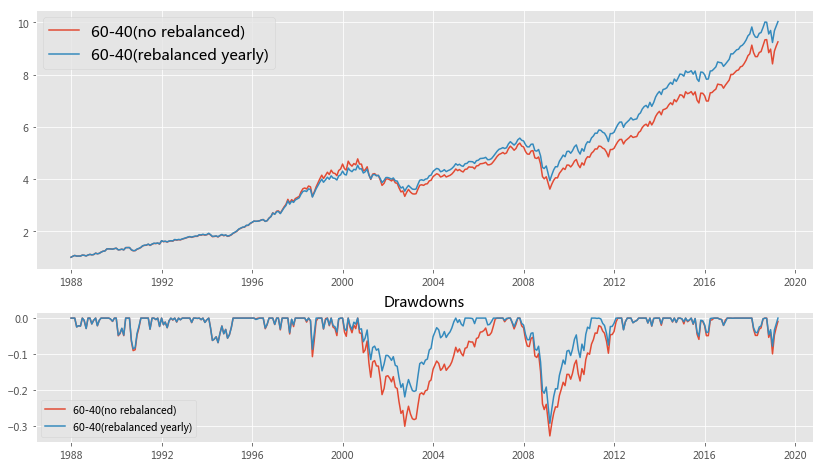

In [30]:
backtest.DD_plot(portfolios_re1yr[['60-40(no rebalanced)', '60-40(rebalanced yearly)']])

# 再平衡(半年) 

In [31]:
portfolios_re6m = pd.DataFrame()

In [32]:
portfolios_re6m['60-40(no rebalanced)']  = backtest.No_rebalance(weight_60_40)
portfolios_re6m['60-40(semi-yearly)']  = backtest.Rebalance(weight_60_40, freq='6m')
portfolios_re6m['tobias(no rebalanced)']  = backtest.No_rebalance(weight_tobias)
portfolios_re6m['tobias(semi-yearly)']  = backtest.Rebalance(weight_tobias, freq='6m')
portfolios_re6m['bernstein(no rebalanced)']  = backtest.No_rebalance(weight_bernstein)
portfolios_re6m['bernstein(semi-yearly)']  = backtest.Rebalance(weight_bernstein, freq='6m')
portfolios_re6m['ivy(no rebalanced)']  = backtest.No_rebalance(weight_ivy)
portfolios_re6m['ivy(semi-yearly)']  = backtest.Rebalance(weight_ivy, freq='6m')
portfolios_re6m['swensen(no rebalanced)']  = backtest.No_rebalance(weight_swensen)
portfolios_re6m['swensen(semi-yearly)']  = backtest.Rebalance(weight_swensen, freq='6m')

In [33]:
strategy_performance(portfolios_re6m)

,annual_return,return_volatility,sharpe_ratio,max_drawdown
60-40(no rebalanced),0.073589,0.092894,0.576889,-0.328168
60-40(semi-yearly),0.074948,0.084038,0.653850,-0.305240
tobias(no rebalanced),0.062199,0.090963,0.463911,-0.341753
tobias(semi-yearly),0.060603,0.093730,0.433195,-0.368201
bernstein(no rebalanced),0.069324,0.112194,0.439632,-0.405536
bernstein(semi-yearly),0.067743,0.108594,0.439645,-0.411523
ivy(no rebalanced),0.073214,0.102587,0.518726,-0.471107
ivy(semi-yearly),0.067836,0.093222,0.513140,-0.426429
swensen(no rebalanced),0.078764,0.107518,0.546550,-0.463085
swensen(semi-yearly),0.077156,0.094761,0.603164,-0.410837


# 均線風控

In [34]:
nav_risk12m = backtest.risk_con_meanXm()
nav_risk6m = backtest.risk_con_meanXm(window_months=6)
nav_risk9m = backtest.risk_con_meanXm(window_months=9)
#nav_risk12ewm = backtest.risk_con_meanXm(if_ewm=True)

In [35]:
strategy_performance(nav_risk12m)

,annual_return,return_volatility,sharpe_ratio,max_drawdown
SP500,0.081614,0.103909,0.592964,-0.183949
Russel2000,0.053519,0.128051,0.261765,-0.320696
DM Stocks ex US,0.041028,0.108255,0.194247,-0.333474
EM Stocks,0.093510,0.156242,0.470489,-0.308168
US Bonds,0.052212,0.042919,0.750524,-0.064276
Gold,0.022072,0.118452,0.017494,-0.402308
Commodities,0.052238,0.109435,0.294590,-0.317952
Reits,0.098824,0.119789,0.658018,-0.220423


In [36]:
nav_risk12m.columns = [s+'+risk-control-12m' for s in nav.columns]

In [37]:
nav_risk6m.columns = [s+'+risk-control-6m' for s in nav.columns]
nav_risk9m.columns = [s+'+risk-control-9m' for s in nav.columns]

In [38]:
strategy_performance(nav_risk6m)

,annual_return,return_volatility,sharpe_ratio,max_drawdown
SP500+risk-control-6m,0.065401,0.099209,0.457635,-0.271020
Russel2000+risk-control-6m,0.057289,0.122408,0.304625,-0.271544
DM Stocks ex US+risk-control-6m,0.017554,0.109900,-0.022258,-0.412223
EM Stocks+risk-control-6m,0.108122,0.161200,0.546662,-0.298971
US Bonds+risk-control-6m,0.046402,0.041256,0.639958,-0.064276
Gold+risk-control-6m,0.011755,0.114487,-0.072017,-0.419254
Commodities+risk-control-6m,0.054879,0.102626,0.339868,-0.262128
Reits+risk-control-6m,0.090706,0.113738,0.621652,-0.225154


In [39]:
strategy_performance(nav_risk9m)

,annual_return,return_volatility,sharpe_ratio,max_drawdown
SP500+risk-control-9m,0.079824,0.101084,0.591822,-0.168501
Russel2000+risk-control-9m,0.059295,0.129992,0.302291,-0.384791
DM Stocks ex US+risk-control-9m,0.030168,0.105369,0.096497,-0.333379
EM Stocks+risk-control-9m,0.105182,0.156468,0.544403,-0.345927
US Bonds+risk-control-9m,0.049114,0.041893,0.694962,-0.066659
Gold+risk-control-9m,0.027779,0.116013,0.067053,-0.338912
Commodities+risk-control-9m,0.042828,0.102495,0.222725,-0.254699
Reits+risk-control-9m,0.099613,0.132677,0.600055,-0.468331


In [40]:
strategy_performance(nav_risk12m)

,annual_return,return_volatility,sharpe_ratio,max_drawdown
SP500+risk-control-12m,0.081614,0.103909,0.592964,-0.183949
Russel2000+risk-control-12m,0.053519,0.128051,0.261765,-0.320696
DM Stocks ex US+risk-control-12m,0.041028,0.108255,0.194247,-0.333474
EM Stocks+risk-control-12m,0.093510,0.156242,0.470489,-0.308168
US Bonds+risk-control-12m,0.052212,0.042919,0.750524,-0.064276
Gold+risk-control-12m,0.022072,0.118452,0.017494,-0.402308
Commodities+risk-control-12m,0.052238,0.109435,0.294590,-0.317952
Reits+risk-control-12m,0.098824,0.119789,0.658018,-0.220423


In [41]:
assets = pd.DataFrame()

In [42]:
assets['SP500'] = nav['SP500']
assets['SP500+risk-control-12m'] = nav_risk12m['SP500+risk-control-12m']
assets['Russel2000'] = nav['Russel2000']
assets['Russel2000+risk-control-12m'] = nav_risk12m['Russel2000+risk-control-12m']
assets['DM Stocks ex US'] = nav['DM Stocks ex US']
assets['DM Stocks ex US+risk-control-12m'] = nav_risk12m['DM Stocks ex US+risk-control-12m']
assets['EM Stocks'] = nav['EM Stocks']
assets['EM Stocks+risk-control-12m'] = nav_risk12m['EM Stocks+risk-control-12m']
assets['US Bonds'] = nav['US Bonds']
assets['US Bonds+risk-control-12m'] = nav_risk12m['US Bonds+risk-control-12m']
assets['Gold'] = nav['Gold']
assets['Gold+risk-control-12m'] = nav_risk12m['Gold+risk-control-12m']
assets['Commodities'] = nav['Commodities']
assets['Commodities+risk-control-12m'] = nav_risk12m['Commodities+risk-control-12m']
assets['Reits'] = nav['Reits']
assets['Reits+risk-control-12m'] = nav_risk12m['Reits+risk-control-12m']

In [43]:
strategy_performance(assets)

,annual_return,return_volatility,sharpe_ratio,max_drawdown
SP500,0.080980,0.140666,0.433511,-0.525559
SP500+risk-control-12m,0.081614,0.103909,0.592964,-0.183949
Russel2000,0.084763,0.184024,0.351927,-0.540802
Russel2000+risk-control-12m,0.053519,0.128051,0.261765,-0.320696
DM Stocks ex US,0.029358,0.166409,0.056234,-0.582353
DM Stocks ex US+risk-control-12m,0.041028,0.108255,0.194247,-0.333474
EM Stocks,0.078197,0.224583,0.259133,-0.626678
EM Stocks+risk-control-12m,0.093510,0.156242,0.470489,-0.308168
US Bonds,0.058420,0.044043,0.872318,-0.054186
US Bonds+risk-control-12m,0.052212,0.042919,0.750524,-0.064276


In [44]:
nav.tail()

,SP500,Russel2000,DM Stocks ex US,EM Stocks,US Bonds,Gold,Commodities,Reits
date,,,,,,,,
2018-11-30,11.171159,12.744718,2.389016,9.9472,5.679354,2.521215,2.725688,21.720315
2018-12-31,10.145904,11.209408,2.270619,9.6578,5.801549,2.649225,2.537952,19.933708
2019-01-31,10.944229,12.463377,2.417440,10.4993,5.828860,2.729291,2.676181,22.275473
2019-02-28,11.269589,13.096180,2.473721,10.5095,5.813059,2.712911,2.703275,22.437739
2019-03-29,11.471588,12.798522,2.475979,10.5813,5.924031,2.669655,2.698449,23.189381


In [45]:
nav_risk12m.tail()

,SP500+risk-control-12m,Russel2000+risk-control-12m,DM Stocks ex US+risk-control-12m,EM Stocks+risk-control-12m,US Bonds+risk-control-12m,Gold+risk-control-12m,Commodities+risk-control-12m,Reits+risk-control-12m
date,,,,,,,,
2018-11-30,12.638518,5.12227,3.524989,16.460585,4.723309,1.966766,4.930722,20.055104
2018-12-31,11.478593,5.12227,3.524989,16.460585,4.824933,1.966766,4.930722,18.405469
2019-01-31,11.478593,5.12227,3.524989,16.460585,4.847647,2.026207,4.930722,18.405469
2019-02-28,11.478593,5.12227,3.524989,16.460585,4.834506,2.014046,4.930722,18.539544
2019-03-29,11.684338,5.12227,3.524989,16.460585,4.926797,1.981933,4.930722,19.160600


In [46]:
nav_risk12m.columns = nav.columns
backtest2 = Backtest(nav_risk12m)

In [47]:
portfolios_risk12m_re1yr = pd.DataFrame()

In [48]:
#portfolios_risk12m_re1yr['SP500'] = nav['SP500']
#portfolios_risk12m_re1yr['60-40(年底再平衡)'] = portfolios_re1yr['60-40(年底再平衡)']
portfolios_risk12m_re1yr['60-40(rebalanced yearly)']  = portfolios_re1yr['60-40(rebalanced yearly)']
portfolios_risk12m_re1yr['60-40(rebalanced yearly+risk-control-12m)']  = backtest2.Rebalance(weight_60_40, freq='1yr')
#portfolios_risk12m_re1yr['tobias(年底再平衡)'] = portfolios_re1yr['tobias(年底再平衡)']
portfolios_risk12m_re1yr['tobias(rebalanced yearly)']  = portfolios_re1yr['tobias(rebalanced yearly)']
portfolios_risk12m_re1yr['tobias(rebalanced yearly+risk-control-12m)']  = backtest2.Rebalance(weight_tobias, freq='1yr')
#portfolios_risk12m_re1yr['bernstein(年底再平衡)'] = portfolios_re1yr['bernstein(年底再平衡)']
portfolios_risk12m_re1yr['bernstein(rebalanced yearly)']  = portfolios_re1yr['bernstein(rebalanced yearly)']
portfolios_risk12m_re1yr['bernstein(rebalanced yearly+risk-control-12m)']  = backtest2.Rebalance(weight_bernstein, freq='1yr')
#portfolios_risk12m_re1yr['ivy(年底再平衡)'] = portfolios_re1yr['ivy(年底再平衡)']
portfolios_risk12m_re1yr['ivy(rebalanced yearly)']  = portfolios_re1yr['ivy(rebalanced yearly)']
portfolios_risk12m_re1yr['ivy(rebalanced yearly+risk-control-12m)']  = backtest2.Rebalance(weight_ivy, freq='1yr')
#portfolios_risk12m_re1yr['swensen(年底再平衡)'] = portfolios_re1yr['swensen(年底再平衡)']
portfolios_risk12m_re1yr['swensen(rebalanced yearly)']  = portfolios_re1yr['swensen(rebalanced yearly)']
portfolios_risk12m_re1yr['swensen(rebalanced yearly+risk-control-12m)']  = backtest2.Rebalance(weight_swensen, freq='1yr')

In [49]:
strategy_performance(portfolios_risk12m_re1yr)

,annual_return,return_volatility,sharpe_ratio,max_drawdown
60-40(rebalanced yearly),0.076354,0.083814,0.672365,-0.293314
60-40(rebalanced yearly+risk-control-12m),0.071833,0.066528,0.779115,-0.102819
tobias(rebalanced yearly),0.061988,0.093007,0.451447,-0.356556
tobias(rebalanced yearly+risk-control-12m),0.061486,0.064531,0.642882,-0.090484
bernstein(rebalanced yearly),0.068759,0.108218,0.450561,-0.402814
bernstein(rebalanced yearly+risk-control-12m),0.060230,0.071410,0.563370,-0.114868
ivy(rebalanced yearly),0.068874,0.093018,0.525428,-0.431021
ivy(rebalanced yearly+risk-control-12m),0.069359,0.059450,0.830259,-0.119117
swensen(rebalanced yearly),0.078827,0.094290,0.623892,-0.401215
swensen(rebalanced yearly+risk-control-12m),0.074942,0.062309,0.881772,-0.082274


# 比較

In [50]:
strategy_performance(nav)

,annual_return,return_volatility,sharpe_ratio,max_drawdown
SP500,0.080980,0.140666,0.433511,-0.525559
Russel2000,0.084763,0.184024,0.351927,-0.540802
DM Stocks ex US,0.029358,0.166409,0.056234,-0.582353
EM Stocks,0.078197,0.224583,0.259133,-0.626678
US Bonds,0.058420,0.044043,0.872318,-0.054186
Gold,0.031835,0.151732,0.077999,-0.441747
Commodities,0.032188,0.143962,0.084664,-0.670252
Reits,0.105536,0.178950,0.477992,-0.682965


In [51]:
strategy_performance(portfolios)

,annual_return,return_volatility,sharpe_ratio,max_drawdown
SP500,0.080980,0.140666,0.433511,-0.525559
60-40(no rebalanced),0.073589,0.092894,0.576889,-0.328168
tobias(no rebalanced),0.062199,0.090963,0.463911,-0.341753
bernstein(no rebalanced),0.069324,0.112194,0.439632,-0.405536
ivy(no rebalanced),0.073214,0.102587,0.518726,-0.471107
swensen(no rebalanced),0.078764,0.107518,0.546550,-0.463085


In [52]:
strategy_performance(portfolios_re1yr)

,annual_return,return_volatility,sharpe_ratio,max_drawdown
60-40(no rebalanced),0.073589,0.092894,0.576889,-0.328168
60-40(rebalanced yearly),0.076354,0.083814,0.672365,-0.293314
tobias(no rebalanced),0.062199,0.090963,0.463911,-0.341753
tobias(rebalanced yearly),0.061988,0.093007,0.451447,-0.356556
bernstein(no rebalanced),0.069324,0.112194,0.439632,-0.405536
bernstein(rebalanced yearly),0.068759,0.108218,0.450561,-0.402814
ivy(no rebalanced),0.073214,0.102587,0.518726,-0.471107
ivy(rebalanced yearly),0.068874,0.093018,0.525428,-0.431021
swensen(no rebalanced),0.078764,0.107518,0.546550,-0.463085
swensen(rebalanced yearly),0.078827,0.094290,0.623892,-0.401215


In [53]:
strategy_performance(portfolios_risk12m_re1yr)

,annual_return,return_volatility,sharpe_ratio,max_drawdown
60-40(rebalanced yearly),0.076354,0.083814,0.672365,-0.293314
60-40(rebalanced yearly+risk-control-12m),0.071833,0.066528,0.779115,-0.102819
tobias(rebalanced yearly),0.061988,0.093007,0.451447,-0.356556
tobias(rebalanced yearly+risk-control-12m),0.061486,0.064531,0.642882,-0.090484
bernstein(rebalanced yearly),0.068759,0.108218,0.450561,-0.402814
bernstein(rebalanced yearly+risk-control-12m),0.060230,0.071410,0.563370,-0.114868
ivy(rebalanced yearly),0.068874,0.093018,0.525428,-0.431021
ivy(rebalanced yearly+risk-control-12m),0.069359,0.059450,0.830259,-0.119117
swensen(rebalanced yearly),0.078827,0.094290,0.623892,-0.401215
swensen(rebalanced yearly+risk-control-12m),0.074942,0.062309,0.881772,-0.082274


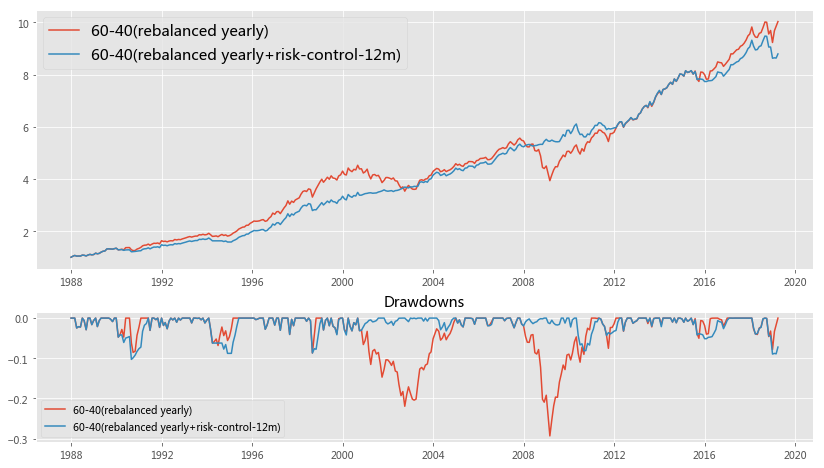

In [54]:
backtest.DD_plot(portfolios_risk12m_re1yr[['60-40(rebalanced yearly)','60-40(rebalanced yearly+risk-control-12m)']])

In [55]:
def return_by_year(nav):
    returns = nav.pct_change().dropna()
    returns['year'] = [s.year for s in returns.index]
    returns = returns.groupby('year').apply(lambda data: np.cumprod(1+data).iloc[-1]-1)
    return returns.drop(['year'], axis=1)

In [56]:
 return_by_year(assets).tail(20)*100

,SP500,SP500+risk-control-12m,Russel2000,Russel2000+risk-control-12m,DM Stocks ex US,DM Stocks ex US+risk-control-12m,EM Stocks,EM Stocks+risk-control-12m,US Bonds,US Bonds+risk-control-12m,Gold,Gold+risk-control-12m,Commodities,Commodities+risk-control-12m,Reits,Reits+risk-control-12m
year,,,,,,,,,,,,,,,,
2000,-10.139187,-2.712268,-4.316409,-9.274740,-15.205904,-8.717416,-31.798864,-16.434329,13.516700,11.543904,-5.468750,-7.207215,31.841548,31.841548,26.365289,15.641174
2001,-13.042688,0.000000,1.021543,-2.357692,-22.611079,0.000000,-4.910273,0.000000,6.747801,6.747801,2.460973,0.081777,-19.508212,-9.411790,13.932873,13.932873
2002,-23.365968,0.000000,-21.580195,-12.229861,-17.516624,-4.139956,-7.974165,-7.177064,11.793476,11.793476,24.771464,24.771464,25.905148,12.094005,3.820984,3.396885
2003,26.380396,21.266850,45.372463,39.687576,35.282633,28.391679,51.590263,40.369008,2.241427,-1.336582,19.365034,19.365034,23.931569,23.931569,37.133527,30.477244
2004,8.993453,8.993453,16.997624,12.576051,17.591192,17.591192,22.446813,17.821818,3.537796,2.503471,5.536166,0.695175,9.147940,9.147940,31.577543,31.577543
2005,3.001023,3.001023,3.323143,-2.931291,10.864545,10.864545,30.305993,30.305993,2.791886,2.791886,17.915384,12.974039,21.363340,12.184805,12.162639,12.162639
2006,13.619431,13.619431,16.999562,13.757386,23.471398,23.471398,29.182709,29.182709,3.079188,1.881001,23.152805,23.152805,2.071510,-2.551052,35.060872,35.060872
2007,3.529578,3.529578,-2.747936,-6.074533,8.622884,8.622884,36.480579,36.480579,9.012436,9.012436,30.940788,30.940788,16.230340,15.986196,-15.691743,-5.888678
2008,-38.485794,0.000000,-34.800408,-8.101994,-45.085561,-9.286133,-54.476192,-24.561271,13.737126,13.737126,5.799448,-0.305865,-35.649196,3.974355,-37.727636,-10.188534


In [57]:
assets.to_excel('12M均線風控.xlsx')

In [58]:
portfolios_risk12m_re1yr['SP500'] = nav['SP500']

In [59]:
portfolios_finally = pd.DataFrame()
portfolios_finally['SP500'] = nav['SP500']
portfolios_finally['60-40(rebalanced yearly+risk-control-12m)'] = portfolios_risk12m_re1yr['60-40(rebalanced yearly+risk-control-12m)']
portfolios_finally['tobias(rebalanced yearly+risk-control-12m)'] = portfolios_risk12m_re1yr['tobias(rebalanced yearly+risk-control-12m)']
portfolios_finally['bernstein(rebalanced yearly+risk-control-12m)'] = portfolios_risk12m_re1yr['bernstein(rebalanced yearly+risk-control-12m)']
portfolios_finally['ivy(rebalanced yearly+risk-control-12m)'] = portfolios_risk12m_re1yr['ivy(rebalanced yearly+risk-control-12m)']
portfolios_finally['swensen(rebalanced yearly+risk-control-12m)'] = portfolios_risk12m_re1yr['swensen(rebalanced yearly+risk-control-12m)']

In [60]:
port_return_by_year = return_by_year(portfolios_finally).tail(20)*100

In [61]:
port_return_by_year.tail(10)

,SP500,60-40(rebalanced yearly+risk-control-12m),tobias(rebalanced yearly+risk-control-12m),bernstein(rebalanced yearly+risk-control-12m),ivy(rebalanced yearly+risk-control-12m),swensen(rebalanced yearly+risk-control-12m)
year,,,,,,
2010,12.782710,-0.092866,-2.362298,-0.652034,4.512647,5.104287
2011,-0.002385,1.602103,-0.859380,-2.457915,-5.151530,-1.980509
2012,13.404792,5.999076,6.530856,5.450899,6.831221,8.227089
2013,29.601245,17.145598,15.829935,21.123261,7.646004,9.617400
2014,11.390638,8.293792,3.803337,1.027151,6.371753,8.956806
2015,-0.726602,-3.437046,-6.223130,-5.606194,-5.804042,-5.929062
2016,9.535016,4.830938,1.403456,5.432991,2.481592,3.046192
2017,19.419965,11.758317,13.822229,13.652669,9.073197,11.645004
2018,-6.237260,-4.800254,-3.736801,-3.194946,-3.785037,-4.169108


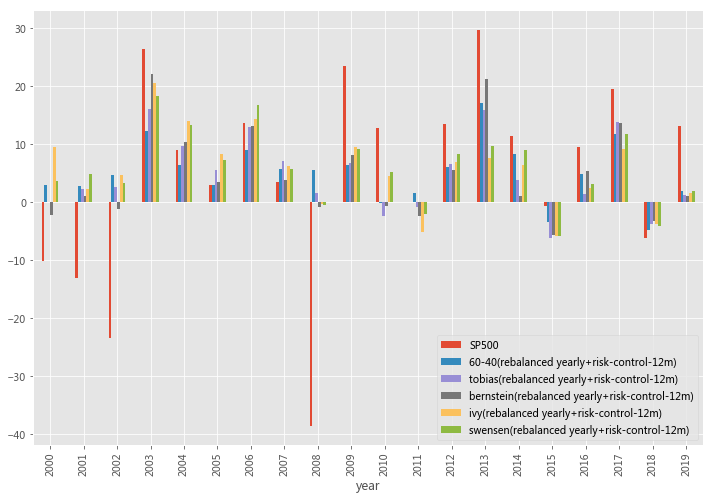

In [62]:
fig_size[0] = 12
fig_size[1] = 8
port_return_by_year.plot.bar()

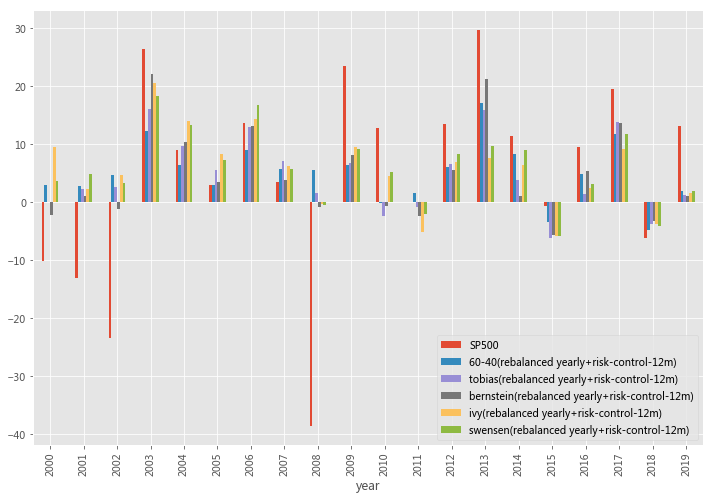

In [63]:
port_return_by_year.plot.bar()

# Relative momentum rotation

In [64]:
def assign_to_weight(df):
    df[df<=4] = 0
    df[df>=5] = 0.25
    return df

In [65]:
monthly_returns = nav.pct_change()

In [66]:
mom1m = nav.pct_change(1)
mom3m = nav.pct_change(3)
mom6m = nav.pct_change(6)
mom9m = nav.pct_change(9)
mom12m = nav.pct_change(12)

In [67]:
mom1m_rank = mom1m.rank(axis=1)
mom3m_rank = mom3m.rank(axis=1)
mom6m_rank = mom6m.rank(axis=1)
mom9m_rank = mom9m.rank(axis=1)
mom12m_rank = mom12m.rank(axis=1)

In [68]:
mom1m_weight = mom1m_rank.apply(lambda df:assign_to_weight(df))
mom3m_weight = mom3m_rank.apply(lambda df:assign_to_weight(df))
mom6m_weight = mom6m_rank.apply(lambda df:assign_to_weight(df))
mom9m_weight = mom9m_rank.apply(lambda df:assign_to_weight(df))
mom12m_weight = mom12m_rank.apply(lambda df:assign_to_weight(df))

In [79]:
mom_df = pd.DataFrame()

In [80]:
mom_df['SP500'] = nav['SP500']

In [81]:
mom_df['mom1m_nav'] = np.cumprod(1+(monthly_returns*(mom1m_weight).shift(1)).dropna().sum(axis=1))
mom_df['mom3m_nav'] = np.cumprod(1+(monthly_returns*(mom3m_weight).shift(1)).dropna().sum(axis=1))
mom_df['mom6m_nav'] = np.cumprod(1+(monthly_returns*(mom6m_weight).shift(1)).dropna().sum(axis=1))
mom_df['mom9m_nav'] = np.cumprod(1+(monthly_returns*(mom9m_weight).shift(1)).dropna().sum(axis=1))
mom_df['mom12m_nav'] = np.cumprod(1+(monthly_returns*(mom12m_weight).shift(1)).dropna().sum(axis=1))

In [82]:
strategy_performance(mom_df)

,annual_return,return_volatility,sharpe_ratio,max_drawdown
SP500,0.080980,0.141571,0.430740,-0.525559
mom1m_nav,0.103090,0.111389,0.745945,-0.289983
mom3m_nav,0.084858,0.109988,0.589681,-0.356907
mom6m_nav,0.080756,0.108757,0.558636,-0.282990
mom9m_nav,0.092530,0.110110,0.658701,-0.296426
mom12m_nav,0.093507,0.111041,0.661978,-0.314947


In [83]:
mom = (mom1m + mom3m + mom6m + mom9m  + mom12m)

In [84]:
mom.tail()

,SP500,Russel2000,DM Stocks ex US,EM Stocks,US Bonds,Gold,Commodities,Reits
date,,,,,,,,
2018-11-30,0.049038,-0.159436,-0.391998,-0.410039,0.000772,-0.156108,-0.161439,0.323829
2018-12-31,-0.422425,-0.744848,-0.603865,-0.545950,0.095926,0.103539,-0.496760,-0.212650
2019-01-31,0.014804,-0.074163,-0.267340,-0.110495,0.129878,0.183901,-0.179275,0.495244
2019-02-28,0.053527,-0.010372,-0.129659,-0.130175,0.093007,0.171037,-0.159101,0.386717
2019-03-29,0.237243,-0.029549,-0.065806,0.005262,0.170761,0.083784,-0.084206,0.588884


In [85]:
mom_rank = mom.rank(axis=1)

In [86]:
mom_weight = mom_rank.apply(lambda df:assign_to_weight(df))

In [87]:
mom_weight.shift(1).tail(10)

,SP500,Russel2000,DM Stocks ex US,EM Stocks,US Bonds,Gold,Commodities,Reits
date,,,,,,,,
2018-06-29,0.25,0.25,0.00,0.0,0.00,0.00,0.25,0.25
2018-07-31,0.25,0.25,0.00,0.0,0.00,0.00,0.25,0.25
2018-08-31,0.25,0.25,0.25,0.0,0.00,0.00,0.00,0.25
2018-09-28,0.25,0.25,0.00,0.0,0.25,0.00,0.00,0.25
2018-10-31,0.25,0.25,0.00,0.0,0.00,0.00,0.25,0.25
2018-11-30,0.25,0.00,0.00,0.0,0.25,0.00,0.25,0.25
2018-12-31,0.25,0.00,0.00,0.0,0.25,0.25,0.00,0.25
2019-01-31,0.25,0.00,0.00,0.0,0.25,0.25,0.00,0.25
2019-02-28,0.25,0.00,0.00,0.0,0.25,0.25,0.00,0.25


In [88]:
mom_df['combined_mom_nav'] = np.cumprod(1+(monthly_returns*(mom_weight).shift(1)).dropna().sum(axis=1))

In [90]:
strategy_performance(mom_df[['SP500', 'combined_mom_nav']])

,annual_return,return_volatility,sharpe_ratio,max_drawdown
SP500,0.080980,0.141571,0.430740,-0.525559
combined_mom_nav,0.095065,0.108923,0.689164,-0.309769


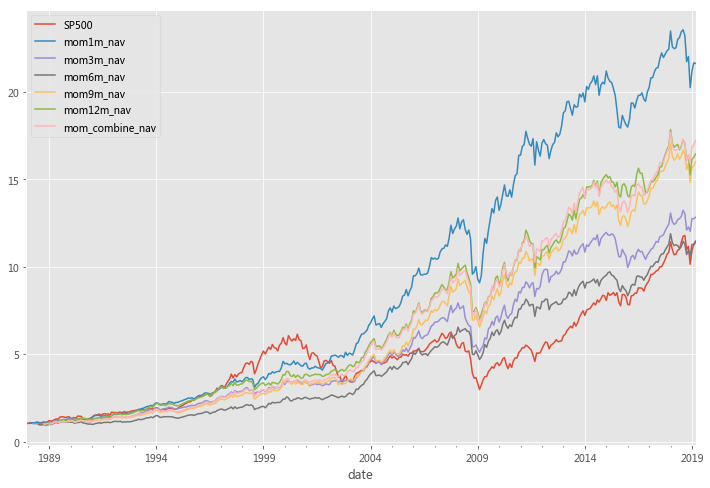

In [78]:
mom_df.plot()

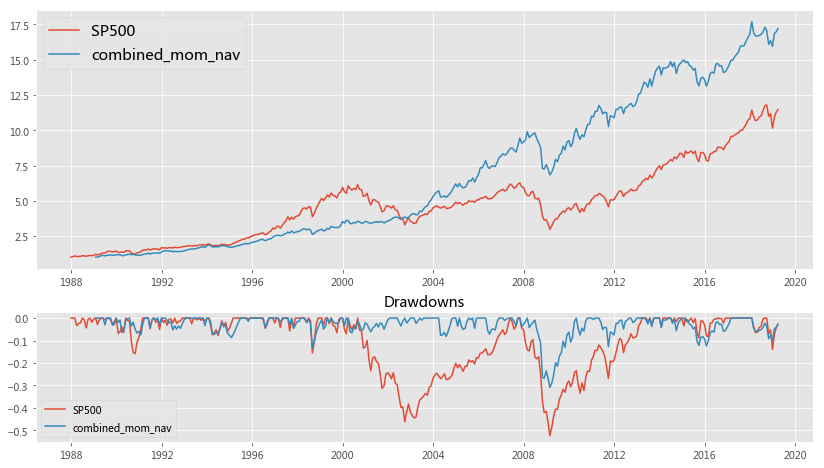

In [92]:
backtest2.DD_plot(mom_df[['SP500', 'combined_mom_nav']])

In [93]:
return_by_year_mom = return_by_year(mom_df).tail(20)*100

In [94]:
return_by_year_mom.tail(20)

,SP500,mom1m_nav,mom3m_nav,mom6m_nav,mom9m_nav,mom12m_nav,combined_mom_nav
year,,,,,,,
2000,-10.139187,-3.002655,0.891980,3.980992,0.613606,-0.183341,0.023837
2001,-13.042688,0.228286,-2.948302,-1.151194,0.604576,0.336173,1.395091
2002,-23.365968,10.478036,6.512299,7.437256,1.885643,11.161025,10.876626
2003,26.380396,34.946755,28.903410,39.191673,33.132303,28.432402,33.606565
2004,8.993453,14.926042,12.539273,14.233402,12.929890,14.118926,16.830947
2005,3.001023,15.658074,8.510959,11.103055,13.126014,11.357995,10.274969
2006,13.619431,18.000365,20.526224,11.795167,24.877786,19.026618,19.158406
2007,3.529578,16.568946,12.995421,14.319640,16.697530,14.144483,12.687344
2008,-38.485794,-17.740561,-26.751225,-14.366991,-15.971729,-18.860426,-17.565258


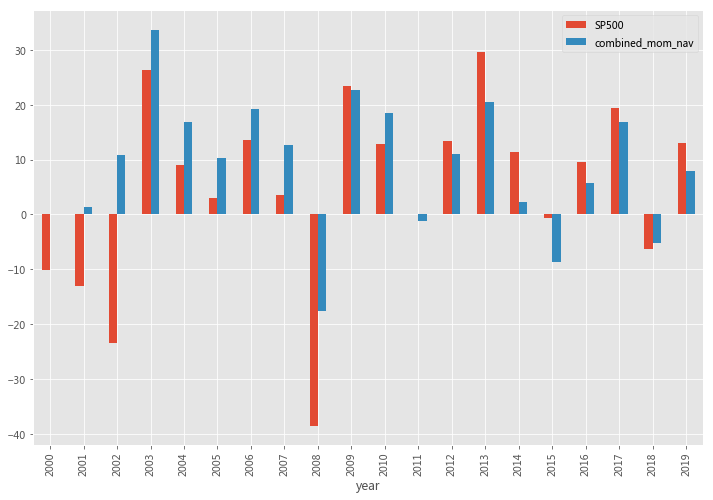

In [96]:
fig_size[0] = 12
fig_size[1] = 8
return_by_year_mom[['SP500', 'combined_mom_nav']].plot.bar()

In [97]:
mom_weight.shift(1).tail(10)

,SP500,Russel2000,DM Stocks ex US,EM Stocks,US Bonds,Gold,Commodities,Reits
date,,,,,,,,
2018-06-29,0.25,0.25,0.00,0.0,0.00,0.00,0.25,0.25
2018-07-31,0.25,0.25,0.00,0.0,0.00,0.00,0.25,0.25
2018-08-31,0.25,0.25,0.25,0.0,0.00,0.00,0.00,0.25
2018-09-28,0.25,0.25,0.00,0.0,0.25,0.00,0.00,0.25
2018-10-31,0.25,0.25,0.00,0.0,0.00,0.00,0.25,0.25
2018-11-30,0.25,0.00,0.00,0.0,0.25,0.00,0.25,0.25
2018-12-31,0.25,0.00,0.00,0.0,0.25,0.25,0.00,0.25
2019-01-31,0.25,0.00,0.00,0.0,0.25,0.25,0.00,0.25
2019-02-28,0.25,0.00,0.00,0.0,0.25,0.25,0.00,0.25


In [98]:
comparison_df = pd.DataFrame()

In [99]:
comparison_df['SP500'] = nav['SP500']
comparison_df['combined_mom_nav'] = mom_df['combined_mom_nav']
#comparison_df['60-40(年底再平衡)+風控'] = portfolios_risk12m_re1yr['60-40(年底再平衡)+風控']

In [100]:
comparison_df['equal_weighted'] = np.cumprod(1+monthly_returns.mean(axis=1).fillna(0))

In [104]:
comparison_df.tail()

,SP500,combined_mom_nav,equal_weighted
date,,,
2018-11-30,11.171159,16.354595,8.125846
2018-12-31,10.145904,15.938603,7.750291
2019-01-31,10.944229,16.859425,8.282365
2019-02-28,11.269589,16.978708,8.399820
2019-03-29,11.471588,17.210336,8.439509


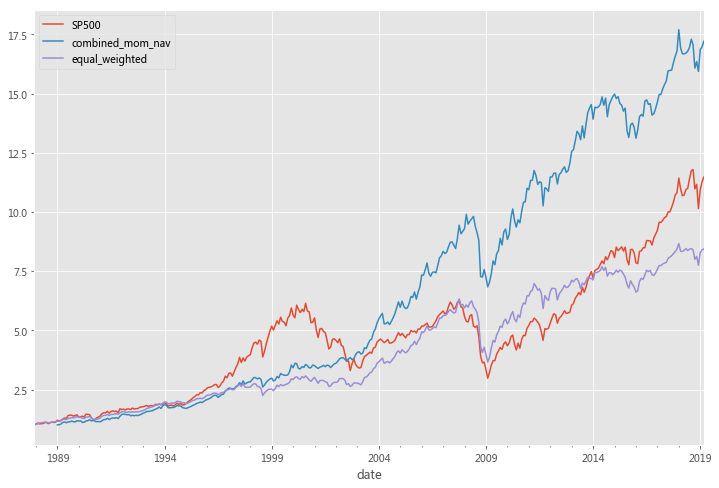

In [105]:
comparison_df.plot()

In [107]:
strategy_performance(comparison_df[['combined_mom_nav', 'equal_weighted']])

,annual_return,return_volatility,sharpe_ratio,max_drawdown
combined_mom_nav,0.095065,0.108923,0.689164,-0.309769
equal_weighted,0.070442,0.106472,0.473761,-0.421222


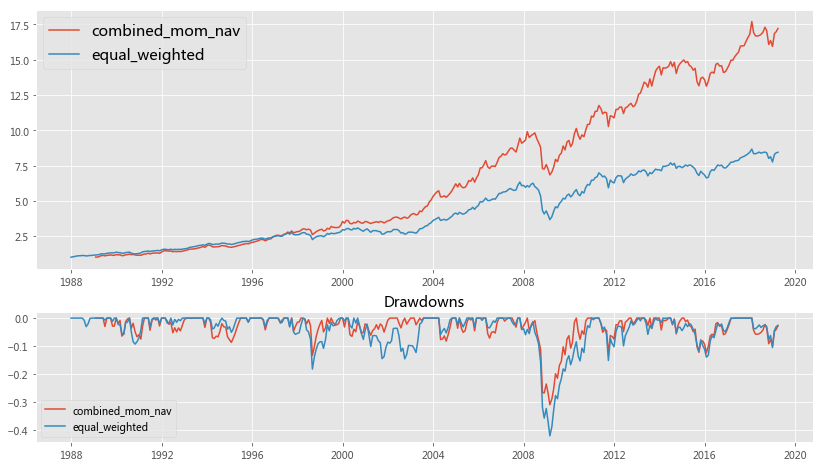

In [108]:
backtest2.DD_plot(comparison_df[['combined_mom_nav', 'equal_weighted']])

In [123]:
weights = mom_weight.shift(1).dropna()

In [129]:
sum(abs(weights.iloc[1] - weights.iloc[0]))

0.5

In [142]:
turnover = pd.DataFrame(np.zeros(len(weights.index)) ,columns=['turnover'],index=weights.index)

In [143]:
for i in range(len(weights.index)-1):
    turnover.iloc[i+1] = sum(abs(weights.iloc[i+1] - weights.iloc[i]))/2
    

In [144]:
weights.tail()

,SP500,Russel2000,DM Stocks ex US,EM Stocks,US Bonds,Gold,Commodities,Reits
date,,,,,,,,
2018-11-30,0.25,0.0,0.0,0.0,0.25,0.00,0.25,0.25
2018-12-31,0.25,0.0,0.0,0.0,0.25,0.25,0.00,0.25
2019-01-31,0.25,0.0,0.0,0.0,0.25,0.25,0.00,0.25
2019-02-28,0.25,0.0,0.0,0.0,0.25,0.25,0.00,0.25
2019-03-29,0.25,0.0,0.0,0.0,0.25,0.25,0.00,0.25


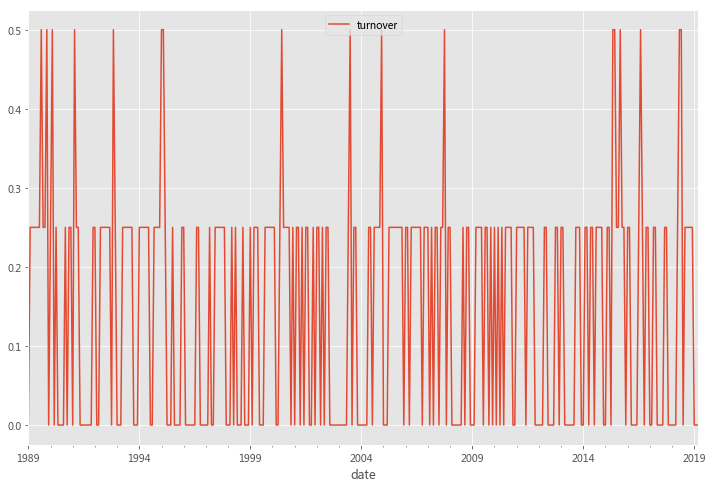

In [147]:
fig_size[0] = 12
fig_size[1] = 8
turnover.plot()

In [153]:
turnover['12M-mean-turn'] = turnover['turnover'].rolling(12).mean()


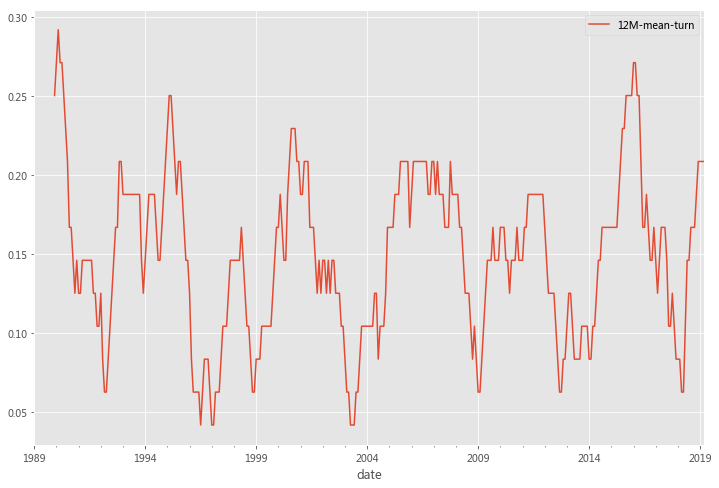

In [156]:
turnover['12M-mean-turn'].plot()
plt.legend()

# +12m 風控

In [112]:
monthly_returns_risk12m = nav_risk12m.pct_change()

In [117]:
comparison_df['combined_mom+risk_control_12m'] = np.cumprod(1+(monthly_returns_risk12m*(mom_weight).shift(1)).dropna().sum(axis=1))

In [119]:
strategy_performance(comparison_df[['combined_mom_nav','combined_mom+risk_control_12m']])

,annual_return,return_volatility,sharpe_ratio,max_drawdown
combined_mom_nav,0.095065,0.108923,0.689164,-0.309769
combined_mom+risk_control_12m,0.089027,0.095350,0.723934,-0.147989


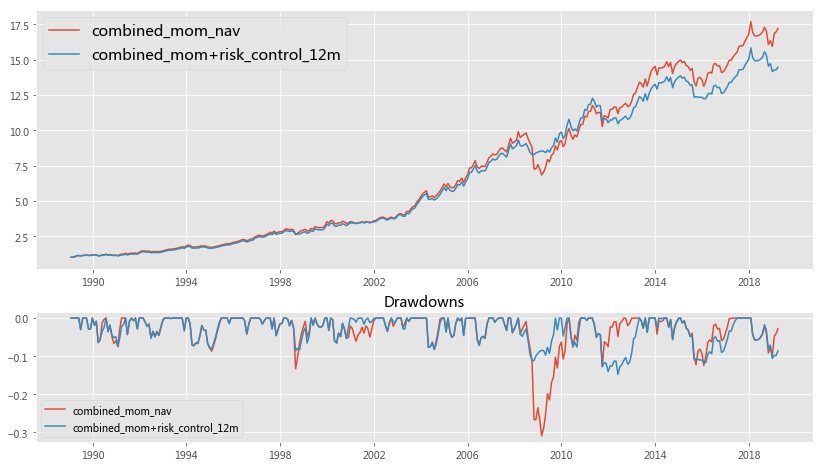

In [120]:
backtest2.DD_plot(comparison_df[['combined_mom_nav','combined_mom+risk_control_12m']])

In [107]:
return_by_year_comparison_df = return_by_year(comparison_df).tail(20)*100

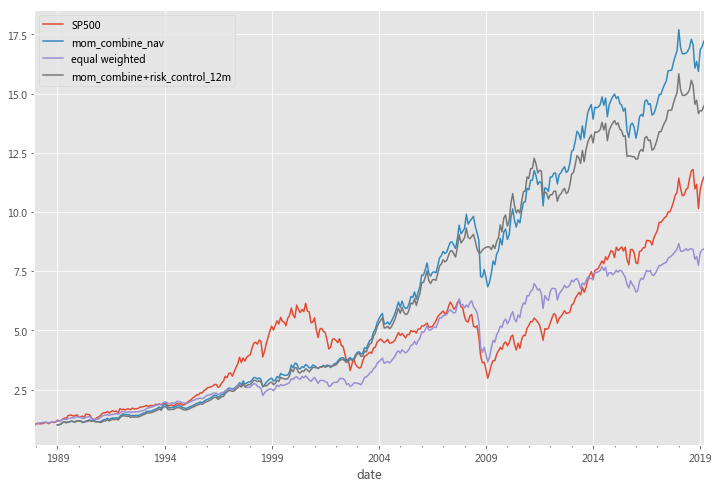

In [110]:
comparison_df.plot()

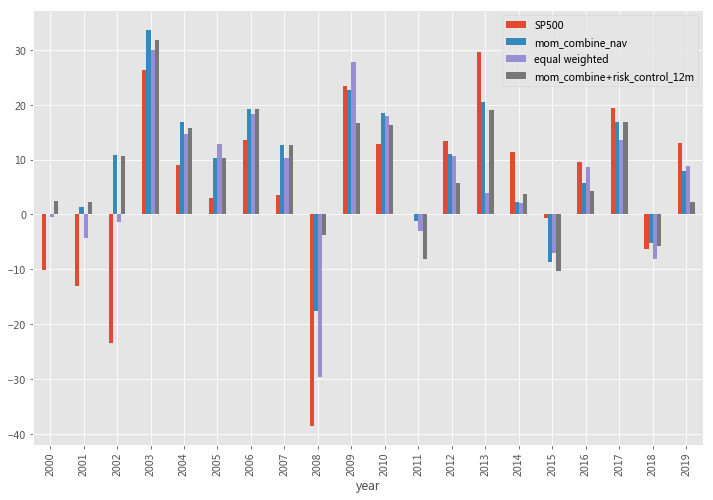

In [108]:
return_by_year_comparison_df.plot.bar()

In [275]:
monthly_returns.tail()

,標普500,羅素2000,國際發達市場股票(除美),新興市場股票,美國公債,黃金,大宗商品,美國房地產
date,,,,,,,,
2018-11-30,0.017859,0.014459,-0.003091,0.040589,0.008876,0.004742,-0.005631,0.047377
2018-12-31,-0.091777,-0.120466,-0.049559,-0.029094,0.021516,0.050773,-0.068876,-0.082255
2019-01-31,0.078684,0.111868,0.064661,0.087132,0.004708,0.030222,0.054465,0.117478
2019-02-28,0.029729,0.050773,0.023281,0.000971,-0.002711,-0.006002,0.010124,0.007285
2019-03-29,0.017924,-0.022729,0.000913,0.006832,0.019090,-0.015944,-0.001785,0.033499


In [273]:
monthly_returns_risk12m.tail()

,標普500,羅素2000,國際發達市場股票(除美),新興市場股票,美國公債,黃金,大宗商品,美國房地產
date,,,,,,,,
2018-11-30,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.047377
2018-12-31,-0.091777,0.0,0.0,0.0,0.021516,0.000000,0.0,-0.082255
2019-01-31,0.000000,0.0,0.0,0.0,0.004708,0.030222,0.0,0.000000
2019-02-28,0.000000,0.0,0.0,0.0,-0.002711,-0.006002,0.0,0.007285
2019-03-29,0.017924,0.0,0.0,0.0,0.019090,-0.015944,0.0,0.033499


In [274]:
mom_weight.tail()

,標普500,羅素2000,國際發達市場股票(除美),新興市場股票,美國公債,黃金,大宗商品,美國房地產
date,,,,,,,,
2018-11-30,0.25,0.0,0.0,0.0,0.25,0.25,0.0,0.25
2018-12-31,0.25,0.0,0.0,0.0,0.25,0.25,0.0,0.25
2019-01-31,0.25,0.0,0.0,0.0,0.25,0.25,0.0,0.25
2019-02-28,0.25,0.0,0.0,0.0,0.25,0.25,0.0,0.25
2019-03-29,0.25,0.0,0.0,0.0,0.25,0.25,0.0,0.25


In [81]:
monthly_returns['美國房地產'].tail()

date
2018-11-30    0.047377
2018-12-31   -0.082255
2019-01-31    0.117478
2019-02-28    0.007285
2019-03-29    0.033499
Freq: BM, Name: 美國房地產, dtype: float64